In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn.preprocessing as sk_pre
import sklearn.decomposition as sk_dec
import sklearn.model_selection as sk_mos
import sklearn.neural_network as sk_nn

In [2]:
maestro_data = pd.read_csv("../data/maestro-calculated.csv", low_memory=False)

In [3]:
maestro_data.columns

Index(['regulatory-approaches', 'ib-run-id', 'rules-branch',
       'processing-location-is-eur', 'event-total-time', 'workflow_name',
       'event-processing-time', 'skip-mdl-out', 'business_date', 'setenv',
       'chf-usd-rate', 'parent_uid', 'kafka_offset', 'uid', 'api-version',
       'bsinp-run-id', 'processing-location-is-sec',
       'processing-location-is-pac', 'rd-run-id', 'source-type-is-ib',
       'scenario-workflow', 'business-day', 'event-waiting-time',
       'processing-location-is-ch', 'batch-instance-seq',
       'processing-location-is-ams', 'batch-workflow', 'as-of-date',
       'pb-run-id', 'job_name', 'as-of-datetime', 'source-type-is-pb',
       'process-flag', 'failed-job-status', 'flow-type', 'correlation-id',
       'hac-run-id', 'business-date', 'skip-mdl-landing'],
      dtype='object')

In [4]:
jobs = maestro_data["job_name"].unique()
business_day = maestro_data["business-day"].unique()
print(business_day)

['BD0' 'BD1' 'BD2' 'BD3' 'BD4' 'BD5' nan 'BD6' 'BD7' 'BD8' 'BD9']


In [5]:
jobs[16]

'run-b3std-calculation'

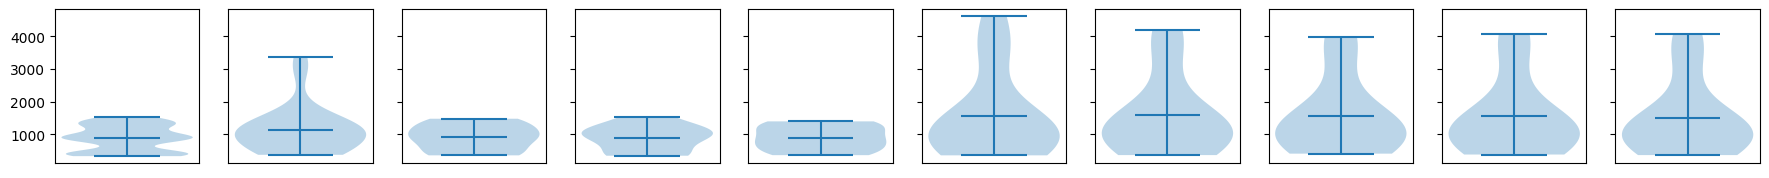

In [52]:
N = 16
COLUMN_NAME = "event-processing-time"
fig, ax = plt.subplots(1, 10, figsize=(2*len(business_day), 2), sharey=True, sharex=True)
for i, bd in enumerate([f"BD{i}" for i in range(10)]):
    ax[i].xaxis.set_visible(False)
    arr = maestro_data.filter(like=COLUMN_NAME)[(maestro_data["job_name"] == jobs[N]) & (maestro_data["business-day"] == bd)]
    nparr = arr.to_numpy()
    try:
        q01, q99 = np.quantile(nparr, 0.05), np.quantile(nparr, 0.95)
        ax[i].violinplot(arr[(q01 <= arr[COLUMN_NAME]) & (arr[COLUMN_NAME] <= q99)], range(1), showmeans=True)
    except:
        print(f"{jobs[N]}, has no entries for BD == {bd}")

In [44]:
job_name = dict.fromkeys(jobs, 0)

# columns_label = {
#     "skip-mdl-out", "batch-workflow", "flow-type",
#     "rules-branch", "business-day", "batch-instance-seq", "ib-run-id",
#     "hac-run-id", "regulatory-approaches"
# }
columns_label = {
    'regulatory-approaches', 'ib-run-id', 'rules-branch',
    'processing-location-is-eur', 'event-total-time', 'skip-mdl-out', 'business_date',
    'setenv', 'bsinp-run-id', 'processing-location-is-sec',
    'processing-location-is-pac', 'rd-run-id', 'source-type-is-ib',
    'business-day', 'processing-location-is-ch', 'batch-instance-seq',
    'processing-location-is-ams', 'batch-workflow',
    'pb-run-id', 'source-type-is-pb', 'process-flag', 'flow-type',
    'hac-run-id', 'skip-mdl-landing'
}
# "event_success_time"
for job in jobs:
    labelizer = dict.fromkeys(columns_label, None)
    maestro_cut = maestro_data[list(columns_label) + ["event-processing-time"]][maestro_data["job_name"] == job].copy()
    maestro_times = maestro_cut.pop("event-processing-time").astype(float)

    q05, q95 = maestro_times.quantile(0.02), maestro_times.quantile(0.98)
    cut = maestro_times[(maestro_times >= q05) & (maestro_times <= q95)]
    mean = cut.mean()
    maestro_times /= mean
    if mean == 0:
        print(f'Skipping job: {job}, q05: {q05:.04}, q95: {q95:.04}, mean: {mean:.04}, len: {len(cut)}')
        continue
    print(f'Starting job: {job}, q05: {q05:.04}, q95: {q95:.04}, mean: {mean:.04}, len: {len(cut)}')

    for i, item in enumerate(list(columns_label)):
        labelizer[item] = sk_pre.LabelEncoder()
        labelizer[item].fit(list(set(maestro_cut[item])))
        maestro_cut[item] = labelizer[item].fit_transform(maestro_cut[item])

    x_train, x_test, y_train, y_test = sk_mos.train_test_split(maestro_cut, maestro_times)

    nn = sk_nn.MLPRegressor(max_iter=10_000, hidden_layer_sizes=[1000, 100])
    nn.fit(x_train, y_train)

    job_name[job] = nn.score(x_test, y_test)

Starting job: open-date-card, q05: 0.0, q95: 3.98, mean: 0.3232, len: 393
Starting job: init-strategic-batch, q05: 0.0, q95: 4.0, mean: 1.068, len: 398
Starting job: start-strategic-batch, q05: 0.0, q95: 3.0, mean: 0.7512, len: 402
Starting job: land-f1ref-data, q05: 30.0, q95: 72.58, mean: 47.31, len: 391
Starting job: reload-f1ref-landing-tables, q05: 29.0, q95: 210.1, mean: 67.15, len: 391
Starting job: land-f1mdl-data, q05: 337.1, q95: 2.36e+03, mean: 1.061e+03, len: 388
Starting job: run-data-staging, q05: 178.0, q95: 1.427e+03, mean: 592.2, len: 388
Starting job: reload-f1mdl-landing-tables, q05: 339.7, q95: 1.135e+03, mean: 647.6, len: 388
Starting job: run-data-harmonization, q05: 223.2, q95: 1.883e+03, mean: 1.008e+03, len: 392
Starting job: reload-staging-tables, q05: 250.1, q95: 790.8, mean: 497.0, len: 387
Starting job: complete-strategic-harmonization-job, q05: 0.0, q95: 2.0, mean: 0.3915, len: 401
Starting job: reload-harmonized-reference-tables, q05: 109.0, q95: 365.1, m

(-1.0, 1.0)

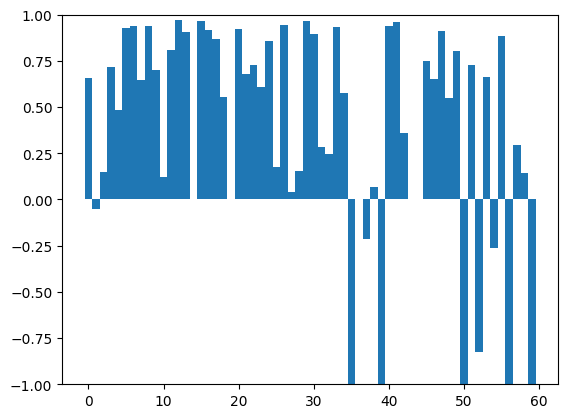

In [45]:
plt.bar(range(len(jobs)), job_name.values(), 1)
plt.ylim(-1, 1)

In [34]:
jobs[-10:]

array(['reload-securitization-tables-b3std',
       'complete-securitization-batch',
       'reload-tactical-tables-post-securitization',
       'run-b3lvr-calculation', 'reload-b3lvr-tables', 'mdl-out-lvr',
       'reload-b3lvr-audit', 'run-lvr-securitization',
       'mdl-out-lvr-with-securitization',
       'reload-securitization-tables-lvr'], dtype=object)

60

In [48]:
np.clip(list(job_name.values()), 0, 1).mean()

0.49964020536419174